# PCA Face Recognition

download the dataset and extract the images

In [7]:
# Download the dataset (subset of CelebA).
!wget -O a3_face_dataset.tar.gz https://www.dropbox.com/s/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz?dl=0

--2021-01-09 13:38:10--  https://www.dropbox.com/s/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz [following]
--2021-01-09 13:38:10--  https://www.dropbox.com/s/raw/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5152c653731ee0dc798e7514a0.dl.dropboxusercontent.com/cd/0/inline/BGqhGJF_VqA5OSlkhgPiLRfw76SbwCr66z2QaQsXvl_mVLObBvox7bHWhqyz1xoGdWPKAC6kYQwSJxdzso-JErq3Onbh11G8xiKqb_eAhIns99RmOY-66MpoaQU6WnzqUxU/file# [following]
--2021-01-09 13:38:10--  https://uc5152c653731ee0dc798e7514a0.dl.dropboxusercontent.com/cd/0/inline/BGqhGJF_VqA5OSlkhgPiLRfw76SbwCr66z2QaQsXvl_mVLObBvox7bHWhqyz1xoGdWPKAC6kY

In [8]:
# Extract the contents of the compressed file.
!tar xzf a3_face_dataset.tar.gz
!ls

a3_face_dataset  a3_face_dataset.tar.gz  sample_data


####Preview a few images from the dataset


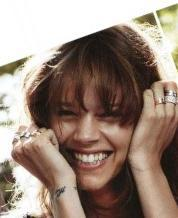

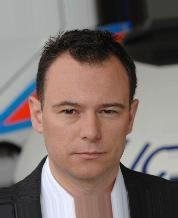

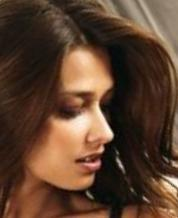

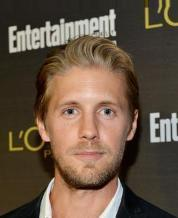

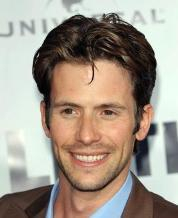

In [9]:
import glob
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Display the first images from the dataset. You can also browse these by
# navigating through the notebook's file system!
sample_images = glob.glob('a3_face_dataset/*.jpg')[:5]
for file_path in sample_images:
  display(Image(file_path))

#### Load the dataset and convert into a NumPy matrix

In [10]:
import cv2
import numpy as np

# Load images in greyscale.
image_paths = list(glob.glob('a3_face_dataset/*.jpg'))
images = np.stack([cv2.imread(str(x), cv2.IMREAD_GRAYSCALE) 
                   for x in image_paths])
print('Original Image Shape (N, H, W):', images.shape)

Original Image Shape (N, H, W): (500, 218, 178)


###Center crop the images and visualize the results

Cropped Image Shape (N, H, W): (500, 108, 88)


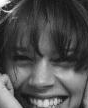

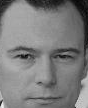

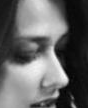

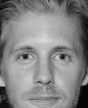

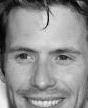

In [11]:
import PIL

# Helper function for cropping the center of the image to remove the background
# and only keep the face.
def center_crop(img):
    h, w = img.shape
    center_y, center_x = h // 2, w // 2
    offset_y, offset_x = center_y // 2, center_x // 2
    return img[center_y - offset_y: center_y + offset_y,
               center_x - offset_x: center_x + offset_x]
  
# Center crop our images.
images = np.stack([center_crop(img) for img in images])
img_height, img_width = images.shape[1:3]
print('Cropped Image Shape (N, H, W):', images.shape)

# Visualize a few results.
for i in range(5):
  display(PIL.Image.fromarray(images[i]))

#### flatten each image into a single vector

In [12]:
# Flatten the images into a (N, HxW) sized array, where N is the number of 
# images and H, W are the dimensions of the image.
num_images = len(images)
images = images.reshape(num_images, -1)
print('Matrix Shape (N, H*W):', images.shape)
print(images)


Matrix Shape (N, H*W): (500, 9504)
[[252 253 254 ...  99 125 140]
 [ 43  39  20 ... 187 170 159]
 [ 23  23  23 ...  17  18  22]
 ...
 [ 57  69  69 ...  23  21  18]
 [170 169 169 ...  53  41  36]
 [124 125 125 ...  26  26  26]]


### 2) PCA Implementation







$$
\mathrm{cov}(A^T)v = \lambda v \\
A^TAv =  \lambda v \\
AA^TAv = A\lambda v \\
$$
____________________________________________________




In [13]:
class PCA:
    """
    Custom implementation of PCA with an interface similar to scikit-learn's version of PCA.
    """

    def __init__(self, n_components):
        self.n_components_ = n_components
        self.mean_ = None
        self.components_ = None
        self.eigenvalues_ = None

    # TODO
    def fit(self, x):
        x = x.astype(np.float32)

        
        # Normalize X so that it has a mean of 0. You can accomplish this
        # by computing the mean image vector and subtracting it from X.
        # The mean should be assigned to the 'self.mean_' attribute.
        # --> Your code here <--

        mean_vector = []
        for i in range(x.shape[1]):
          mean_vector.append(np.mean(x[:,i]))

        self.mean_ = np.array(mean_vector)
        x  = x - mean_vector

        # Set-up your variables, A, and A^TA
        # --> Your code here <--
        A = x.T
        At_A = np.matmul(x,x.T)

        # Sanity check.
        assert A.shape == (9504, 500)
        assert At_A.shape == (500, 500)


     

        # Compute the eigenvectors using the method discussed above.
        # --> Your code here <--
        n = A.shape[1]
        eigenvalues, eigenvectors = np.linalg.eig((1/n)*At_A)

        eigenvectors = np.matmul(A, eigenvectors)

        
        # Tranpose the dimensions of your eigenvectors to return to the
        # notation where each eigenvector is it's own row.
        eigenvectors = eigenvectors.T
        assert eigenvectors.shape == (500, 9504)

         
        # Ensure that each of the N eigenvectors are normalized to a magnitude of 1.
        # --> Your code here <--

        for i in range(eigenvectors.shape[0]):
          norm = np.linalg.norm(eigenvectors[i])
          eigenvectors[i] = eigenvectors[i]/norm


      

        # Only retain the best N components (eigenvectors). These should be assigned
        # to the 'self.components_' attribute.
        # --> Your code here <--
        
        #Sort eigenvalues et eigenvectors en meme temps 
        #Garder top 15
        #Counter? last assignment
        
        p = eigenvalues.argsort()
        eigenvectors = eigenvectors[p]

        top_eigenvectors = eigenvectors[eigenvectors.shape[0]-self.n_components_:eigenvectors.shape[0]]

        self.components_ = top_eigenvectors[::-1]

        # Keep all of the eigenvalues, but make sure to sort them. This is done so we can
        # visualize the variance versus number of components kept later in the assignment.
        # This should be assigned to the 'self.eigenvalues_' attribute.
        # --> Your code here <--
        eigenvalues = -np.sort(-eigenvalues)
        self.eigenvalues_ = eigenvalues

        assert self.eigenvalues_.shape == (500, )

      

    def transform(self, x):
      x = x.astype(np.float32)
      result = None

      # Project the input vector 'x' onto your PCA object's principal
      # components and return the result. Make sure you subtract the mean face
      # like in the fit(...) method.
      # --> Your code here <--

      x  = x - self.mean_

      result = np.dot(x, self.components_.T) 
      result = result / np.linalg.norm(self.components_)

      #result = np.cross(self.components_, x.T)

      return result

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)


   

#### Perform PCA on our image matrix

In [14]:
# Settings
num_components = 50



pca = PCA(num_components)

pca.fit(images)

In [15]:
pca.components_.shape

(50, 9504)

#### Visualize the eigenfaces

Saving mean face...Done.
Saving first ten eigen-faces to ./outputs/...Mean Face


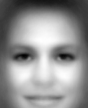

Eigenfaces


In [16]:
import os

# Output directory.
os.makedirs('./eigenfaces/', exist_ok=True)

# Visualize the mean face.
print('Saving mean face...', end='')
mean_face = pca.mean_.reshape(img_height, img_width)
norm_img = cv2.normalize(mean_face, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('./eigenfaces/mean_face.png', norm_img)
print('Done.')

# TODO: Visualize the first few eigenfaces, and save them as './eigenfaces/eigenface_{i}.png'.
print('Saving first ten eigen-faces to ./outputs/...', end='')
eigenfaces = pca.components_.reshape(num_components, img_height, img_width)[:10]


count = 0;
for i in eigenfaces:
  norm_img = cv2.normalize(i, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
  cv2.imwrite('./eigenfaces/eigenface_{' + str(count) + '}.png', norm_img)
  count +=1



# Display the mean face and eigenfaces. You can also browse these by
# navigating through the notebooks file system (see left side toolbar)!
print('Mean Face')
display(Image('./eigenfaces/mean_face.png'))

print('Eigenfaces')
for i in range(10):
  display(Image(f'./eigenfaces/eigenface_{i}.png'))

#### Variance versus number of components

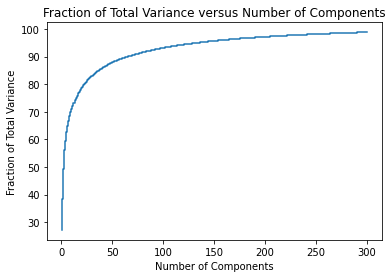

In [17]:
import matplotlib.pyplot as plt

# Compute the cumulative sum of total variance as we increase the number of 
# principal components we use.
n_components_to_plot = 300
total_variance = sum(pca.eigenvalues_)
var_exp = [(i / total_variance) * 100 for i in
           sorted(pca.eigenvalues_, reverse=True)[:n_components_to_plot]]
cum_var_exp = np.cumsum(var_exp)

# Generate the plot.
plt.step(range(1, n_components_to_plot + 1), cum_var_exp)
plt.title('Fraction of Total Variance versus Number of Components')
plt.ylabel('Fraction of Total Variance')
plt.xlabel('Number of Components')
plt.show()

### Face Recognition

In this section, we're going to build a simple face recognition system using eigenfaces. To accomplish this, we're going to take a test image and project it onto our principal components learned from our training set of celebrity faces. Finally, we will compare the resulting vector to all of the other faces in the training set and find the closet match based on Euclidean distance (i.e., 1-nearest-neighbour classification).

For instance, this training set has photos of Obama—in theory then, if we were to test another photo of Obama (not in the training set, cropped and aligned), we should find that the closest match in the training set will also be a photo of Obama.

#### Download the test image

--2021-01-09 13:38:32--  https://www.dropbox.com/s/ffw2621k0gmix1z/006357.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ffw2621k0gmix1z/006357.jpg [following]
--2021-01-09 13:38:33--  https://www.dropbox.com/s/raw/ffw2621k0gmix1z/006357.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd179de13ba2083ef723e85b9c5.dl.dropboxusercontent.com/cd/0/inline/BGr6GpCycxte9wkop2vcdZRc9Nus013GmeXg78nNMY1W0wrHE0nEcwM5qDYnuF6cCmbZkR4v3l5E49WWDbFYUH_ciIeA8fYRLy-HEsZEgBKpyXfal43PmOHzdY1nD3bND7I/file# [following]
--2021-01-09 13:38:33--  https://ucd179de13ba2083ef723e85b9c5.dl.dropboxusercontent.com/cd/0/inline/BGr6GpCycxte9wkop2vcdZRc9Nus013GmeXg78nNMY1W0wrHE0nEcwM5qDYnuF6cCmbZkR4v3l5E49WWDbFYUH_ciIeA8fYRLy-HEsZEgBKpy

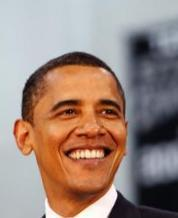

In [18]:
# Download a photo of Obama which isn't in the training set.
!wget -O "006357.jpg" https://www.dropbox.com/s/ffw2621k0gmix1z/006357.jpg?dl=0
display(Image('006357.jpg'))

####  Find the closet image in the training set to our test image

Best match: a3_face_dataset/029695.jpg


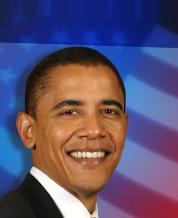

In [19]:
from numpy.linalg import norm

# Load our test image into a NumPy matrix
test_img = center_crop(cv2.imread('006357.jpg', cv2.IMREAD_GRAYSCALE))
test_img = np.expand_dims(test_img.flatten(), axis=0)

# TODO: Transform our training matrix and test image using our PCA implementation
# from earlier.
# --> Your code here <--

test_img = pca.transform(test_img)

training_matrix = []

for i in images:
  training_matrix.append(pca.transform(i))

# TODO: For our face recognition classifier, we will use a 1-nearest-neighbour
# model. The classifier should return the index of the best matching image.
# --> Your code here <--
dists = []
for i in training_matrix:
  dists.append(norm(test_img-i))

best_match_index = np.argmin(dists)

# If all goes well, the best match in our training set should be another
# photo of Obama.
print('Best match:', image_paths[best_match_index])
display(Image(image_paths[best_match_index]))